In [74]:
import os
import time
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
import PIL.Image as Image

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as F


In [76]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, to_grayscale, to_tensor
import torchvision.transforms.functional as F
from torchvision import models

In [77]:

# Preprocessing transformations
Transform = T.Compose([
    T.Resize(256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [78]:
IMAGE_DIMENSION = 256

In [79]:
# Define data transformations
data_transforms = {
    'train': T.Compose([
        T.Resize((IMAGE_DIMENSION, IMAGE_DIMENSION)),
        # T.RandomResizedCrop(224),
        # T.RandomHorizontalFlip(),

        T.ToTensor(),
        # T.Normalize([0.5], [0.5]),
        # T.Grayscale(num_output_channels=3),

        # T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': T.Compose([
        T.Resize((IMAGE_DIMENSION, IMAGE_DIMENSION)),
        # T.CenterCrop(224),

        T.ToTensor(),
        # T.Normalize([0.5], [0.5]),
        # T.Grayscale(num_output_channels=3),


        # T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [80]:
def apply_label_encoding_to_data(data: pd.DataFrame) -> pd.DataFrame:
    class_label_mapping = {}  # Dictionary to map class labels to indices
    unique_classes = data['label'].unique()  # Assuming 'label' is the column containing class labels in your CSV file

    for idx, class_label in enumerate(unique_classes):
        class_label_mapping[class_label] = idx

    # Convert the class labels in your dataset to numeric format
    data['label'] = data['label'].map(class_label_mapping)
    return data

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, labels_path, images_path, transform=None, target_transform=None):
        super().__init__()
        labels = pd.read_csv(labels_path)[:1000]
        if target_transform:
            labels = target_transform(labels)


        self.img_labels = labels

        self.img_dir = images_path

        self.transform = transform

    def __len__(self):
        return min(np.max(self.img_labels['id']), len(os.listdir(self.img_dir)))
        # return len(self.img_labels) - 1

    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:

        (id, label) = self.img_labels.iloc[idx]
        img_path = os.path.join(self.img_dir, str(id) + ".jpg")
        image = to_pil_image(read_image(img_path))

        # image=to_grayscale(image)
        image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


    @property
    def classes(self):
        return self.img_labels['label'].nunique()

In [81]:
class TripletDataset(Dataset):
    """
    This dataset is used for Triplet NN. Here each item is a tuple of three images:
    Anchor, Positive and Negative. This dataset doesn't provide the labels for images:
    we use comparing of images to train a model; so,
    whether the labels are equal IS OUR CRITERIA, not the labels itself.
    """
    def __init__(self, labels_path, images_path, transform=None):
        super().__init__()
        labels = pd.read_csv(labels_path)
        self.img_labels = labels
        self.img_dir = images_path
        self.transform = transform

    def __len__(self):
        a = np.max(self.img_labels['id'])
        b = len(os.listdir(self.img_dir))
        assert a == b
        return a
        # return min(np.max(self.img_labels['id']), len(os.listdir(self.img_dir)))
        # return len(self.img_labels) - 1

    def __get_data_row(self, idx):
        """
        This function gets item label and id.
        :param idx: Pythonic item number (supposed to start from 0)
        :return:
            1) item id (which is equal to image name if the folder) (may start from both 0 or 1, or even other)
            2) label
        """
        id_value, label = self.img_labels.iloc[idx]
        return id_value, label


    def __get_image(self, img_id, kind="anchor", label=None) -> tuple[torch.Tensor, int]:
        img_path = os.path.join(self.img_dir, str(img_id) + ".jpg")
        image = to_pil_image(read_image(img_path))
        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image


    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:
        """ Function to return item by indexing the dataset """

        anchor_id, label = self.__get_data_row(idx)
        anchor = self.__get_image(img_id=anchor_id)

        positive_index = np.random.choice(np.where(self.img_labels['label'] == label)[0])
        positive_id, _ = self.__get_data_row(positive_index)
        positive = self.__get_image(img_id=positive_id)

        negative_labels = np.where(self.img_labels['label'] != label)[0]
        negative_index = np.random.choice(negative_labels)
        negative_id, _ = self.__get_data_row(negative_index)
        negative = self.__get_image(img_id=negative_id)

        return anchor, positive, negative


    @property
    def classes_(self):
        return self.img_labels['label'].unique()





In [82]:
data_path = '../'

In [83]:
# DATA_PATH = {
#     'train': {
#         'images': data_path + "cars_data/train",
#         'labels': data_path + "cars_data/train_labels.csv"
#     },
#     'test': {
#         'images': data_path + "cars_data/test",
#         'labels': data_path + "cars_data/test_labels.csv"
#     },
#     'val': {
#         'images': data_path + "cars_data/test",
#         'labels': data_path + "cars_data/test_labels.csv"
#     },
# }
DATA_PATH = {
    'train': {
        'images': data_path + "Cropped_dogs/train",
        'labels': data_path + "Dogs/train_labels.csv"
    },
    'test': {
        'images': data_path + "Cropped_dogs/test",
        'labels': data_path + "Dogs/test_labels.csv"
    },
    'val': {
        'images': data_path + "Cropped_dogs/val",
        'labels': data_path + "Dogs/val_labels.csv"
    },
}

In [33]:
train_dataset = CustomImageDataset(
    labels_path=DATA_PATH['train']['labels'],
    images_path=DATA_PATH['train']['images'],
    transform=data_transforms['train'],
    target_transform=apply_label_encoding_to_data
)
# test_dataset = CustomImageDataset(
#     labels_path=DATA_PATH['test']['labels'],
#     images_path=DATA_PATH['test']['images'],
#     transform=data_transforms['test'],
#     target_transform=apply_label_encoding_to_data
# )
val_dataset = CustomImageDataset(
    labels_path=DATA_PATH['val']['labels'],
    images_path=DATA_PATH['val']['images'],
    transform=data_transforms['test'],
    target_transform=apply_label_encoding_to_data
)

NameError: name 'CustomImageDataset' is not defined

In [100]:
train_dataset = TripletDataset(
    labels_path=DATA_PATH['train']['labels'],
    images_path=DATA_PATH['train']['images'],
    transform=data_transforms['train'],
)
# test_dataset = CustomImageDataset(
#     labels_path=DATA_PATH['test']['labels'],
#     images_path=DATA_PATH['test']['images'],
#     transform=data_transforms['test'],
#     target_transform=apply_label_encoding_to_data
# )
val_dataset = TripletDataset(
    labels_path=DATA_PATH['val']['labels'],
    images_path=DATA_PATH['val']['images'],
    transform=data_transforms['test'],
)

In [101]:
BATCH_SIZE = 16

In [102]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [103]:
model = models.resnet18(weights='IMAGENET1K_V1')

Our Resnet model has 1000 out features. We will replace this number with **64**

In [104]:
model.fc = nn.Linear(model.fc.in_features, 64)

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Triplet Loss Implementation

In [106]:
triplet_criterion = nn.TripletMarginLoss(margin=1.0, p=2)

Before the training, let's see how our criterion works

In [124]:
def show_loss(loss_list: list) -> None:
    plt.plot(loss_list)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.show()


In [125]:
loss_history = []

Now we will calculate our loss for some items in dataset.

In [126]:
dataset = val_dataset
for i in range(len(dataset)):
    anchor = dataset[i][0]
    positive = dataset[i][1]
    negative = dataset[i][2]

    with torch.no_grad():
        features1 = model(anchor.unsqueeze(0))
        features2 = model(positive.unsqueeze(0))
        features3 = model(negative.unsqueeze(0))


    anchor_embedding = torch.flatten(features1, start_dim=1)
    epositive_mbedding = torch.flatten(features2, start_dim=1)
    negative_embedding = torch.flatten(features3, start_dim=1)

    loss = triplet_criterion(anchor_embedding, epositive_mbedding, negative_embedding)

    # embeddings_data.append(embedding1)
    loss_history.append(loss)



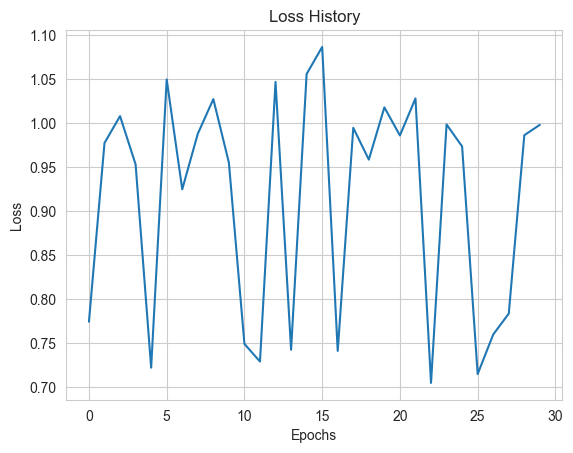

In [127]:
show_loss(loss_history)

Wee can see random distribution of the loss function. Our data embeddings are currently not suitable for data classification: the vector representations poorly capture the similarities and differences between images of different classes.
To address this issue and correctly locate the vectors, we need to train our model using the Triplet Los.


### NN Fine-Tuning

In [54]:
output = triplet_criterion(anchor, positive, negative)

In [57]:
output

tensor(1.0419, grad_fn=<MeanBackward0>)

In [56]:
output.backward()

In [ ]:
def train_iteration_triplet(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for (anchor, positive, negative) in train_loader:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        optimizer.zero_grad()
        output_anchor, output_positive, output_negative = model(anchor, positive, negative)

        loss = criterion(output_anchor, output_positive, output_negative)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)

    return epoch_loss


In [ ]:

def train_model_triplet(model, train_loader, criterion, optimizer, num_epochs=5):
    since = time.time()

    train_loss_history = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)

        for epoch in range(num_epochs):
            epoch_loss = train_iteration_triplet(model, train_loader, criterion, optimizer, device)
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

            train_loss_history.append(epoch_loss)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [65]:
def get_embeddings(model, data_loader, criterion, device='cpu'):
    # model.train()
    model.eval()
    model.to(device)


    with torch.no_grad():
        batch_n = 0
        for images, labels in data_loader:
            # images = images.to(device)
            # labels = labels.to(device)
            # image_batch = images[0]
            # print(image_batch.shape, images.shape)
            try:
                outputs = model(images)
                # # image_embedding = torch.flatten(features, start_dim=1)
                #
                # # loss = criterion(outputs, labels)
                # # loss.backward()
                # print(outputs.shape)

            except RuntimeError:
                print(f"BATCH: {batch_n}. RANGE: {batch_n * BATCH_SIZE} : {(batch_n + 1) * BATCH_SIZE}")
                # raise
            finally:
                batch_n += 1

    return outputs

In [76]:
get_embeddings(model=model, data_loader=train_dataloader, criterion=None, device=device)

In [23]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [77]:
get_embeddings(model=model, data_loader=train_dataset[1], criterion=None, device=device)


ValueError: too many values to unpack (expected 2)

In [142]:

for i in range(3):
    image = train_dataset[i][0]
    with torch.no_grad():
        features = model(image.unsqueeze(0))
    print(torch.flatten(features, start_dim=1).shape)

torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])


In [264]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

In [273]:
model = KMeans(n_clusters=10)

In [274]:
# Apply PCA for dimensionality reduction
pca = PCA(
    n_components=0.8
    # n_components=10,
)

In [275]:
X_train1 = pca.fit_transform(X_train)

In [276]:
X_train1.shape

(200, 69)

In [277]:
X_test1 = pca.transform(X_test)

In [278]:
scaler = StandardScaler()

In [279]:
X_train2 = scaler.fit_transform(X_train1)

In [280]:
X_test2 = scaler.transform(X_test1)

In [281]:
y_test = pd.read_csv(data_path + "Dogs/val_labels.csv")['label']

In [282]:
y_train = pd.read_csv(data_path + "Dogs/train_labels.csv")['label']

In [283]:
knn = KNeighborsClassifier(n_neighbors=5)  # You can choose the number of neighbors (K) here

In [284]:
knn.fit(X_train2, y_train)

KNeighborsClassifier()

In [285]:
model.fit(X_train2)

D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [287]:
model.predict(X_test2)

array([3, 7, 1, 8, 5, 8, 6, 1, 6, 8, 8, 1, 7, 5, 6, 3, 1, 5, 7, 7, 3, 8,
       1, 3, 3, 1, 1, 5, 6, 3])

In [288]:
print(knn.predict(X_test2))

['chihuahua' 'bernese_mountain_dog' 'bernese_mountain_dog' 'chihuahua'
 'dachshund' 'jack_russell' 'golden_retriever' 'border_collie' 'chihuahua'
 'chihuahua' 'chihuahua' 'bernese_mountain_dog' 'chihuahua' 'corgi'
 'jack_russell' 'golden_retriever' 'dachshund' 'border_collie' 'dachshund'
 'jack_russell' 'border_collie' 'jack_russell' 'labrador' 'jack_russell'
 'jack_russell' 'jack_russell' 'jack_russell' 'border_collie'
 'bernese_mountain_dog' 'pug']


In [272]:
knn.score(X_test, y_test)

AttributeError: 'Flags' object has no attribute 'c_contiguous'

array(['bernese_mountain_dog', 'border_collie', 'chihuahua', 'corgi',
       'dachshund', 'golden_retriever', 'jack_russell', 'labrador', 'pug',
       'siberian_husky'], dtype=object)

In [228]:
print(classification_report(y_test, knn.predict(X_test2),
                            target_names=y_test.unique()))

                      precision    recall  f1-score   support

bernese_mountain_dog       0.25      0.67      0.36         3
       border_collie       0.00      0.00      0.00         3
           chihuahua       0.00      0.00      0.00         3
               corgi       0.33      0.33      0.33         3
           dachshund       0.25      0.33      0.29         3
    golden_retriever       0.00      0.00      0.00         3
        jack_russell       0.00      0.00      0.00         3
            labrador       1.00      0.33      0.50         3
                 pug       0.00      0.00      0.00         3
      siberian_husky       0.00      0.00      0.00         3

            accuracy                           0.17        30
           macro avg       0.18      0.17      0.15        30
        weighted avg       0.18      0.17      0.15        30



D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\possessor\Documents\ESSE\IT\ML\CV\cvenv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [246]:

#define arrays
a = [[23, 34, 44, 45, 42, 27, 33, 34]]
b = [[17, 18, 22, 26, 26, 29, 31, 30]]

#calculate Cosine Similarity
cos_sim = np.dot(a[0], b[0])/(np.linalg.norm(a[0]) * np.linalg.norm(b[0]))

cos_sim

0.965195008357566

In [44]:
discriminator = nn.CosineSimilarity(dim=1, eps=1e-8)

In [45]:
torch.Tensor(a).permute(1, 0)

tensor([[23.],
        [34.],
        [44.],
        [45.],
        [42.],
        [27.],
        [33.],
        [34.]])

In [46]:
discriminator(torch.Tensor(a).permute(1, 0), torch.Tensor(b).permute(0, 1))

tensor([0.9803, 0.9803, 0.9803, 0.9803, 0.9803, 0.9803, 0.9803, 0.9803])

In [38]:
torch.Tensor(a).permute(0, 1)

tensor([[23., 34., 44., 45., 42., 27., 33., 34.]])

In [39]:
torch.Tensor(b).permute(1, 0)

tensor([[17.],
        [18.],
        [22.],
        [26.],
        [26.],
        [29.],
        [31.],
        [30.]])